In [1]:
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

$\large{\text{Foundations of Kinematics and Algorithms in Robotics}} \\ \large{\text{Module 5: Graph Theory and Planning Algorithms}}$

$\text{By Jesse Haviland and Peter Corke}$

<br>

### Contents

[1.0 Graphs](#1)  
[2.0 Graph Search](#2)  

In [2]:
# We will do the imports required for this notebook here

# numpy provides import array and linear algebra utilities
import numpy as np

# the robotics toolbox provides robotics specific functionality
import roboticstoolbox as rtb

# spatial math provides objects for representing transformations
import spatialmath.base as smb

import pgraph as pg


<br>

<a id='1'></a>
# 1.0 Graphs
---

A graph is an abstract representation of a set of objects connected by links and depicted visually. Mathematically, a graph is denoted by $G(V, E)$ where $V$ are the vertices or nodes, and $E$ are the links that connect pairs of vertices and are called edges or arcs. Edges can be directed (shown as arrows) or undirected (shown as line segments) as in this case. Edges can have an associated weight or cost associated with moving from one vertex to another. A sequence of edges from one vertex to another is a path, and a sequence that starts and ends at the same vertex is a cycle. An edge from a vertex to itself is a loop. Graphs can be used to represent transport, communications or social networks, and this branch of mathematics is graph theory.

We will illustrate graphs using the Python package `pgraph` that supports embedded graphs where the vertices are associated with a point in an n-dimensional space. To create a new graph

In [3]:
g = pg.UGraph()

and, by default, the vertices of the graph exist in 2-dimensional space. We can add ﬁve randomly-placed vertices to the graph

In [4]:
for i in range(5):
    g.add_vertex(np.random.rand(2))

The method add_vertex returns a reference to the newly created vertex object, but we can obtain the reference by indexing the graph object. For example vertex 1 is

In [5]:
g[1]

UVertex[#1, coord=(0.1245, 0.6847)]

and is an instance of UVertex, a vertex in an undirected graph; it has the coordinate $(0.6028; 0.5449)$; and has been assigned a default name `"#1"` but we could specify a different name. We can also reference a vertex by its name

In [6]:
g["#1"]

UVertex[#1, coord=(0.1245, 0.6847)]

We can create edges between pairs of vertex objects

In [7]:
g.add_edge(g[0], g[1])
g.add_edge(g[0], g[2])
g.add_edge(g[0], g[3])
g.add_edge(g[1], g[2])
g.add_edge(g[1], g[3])
g.add_edge(g[3], g[4])

Edge{[#3] -- [#4], cost=0.4719}

and the add_edge method returns a reference to the edge object just created. By default, the edge cost is the Euclidean distance between the vertices, but this can be overridden by a third argument to add_edge.

A summary of the graph can be displayed

In [8]:
print(g)

UGraph: 5 vertices, 6 edges, 1 component


This graph has one component, that is, all the vertices are connected into one network. The graph can be plotted by

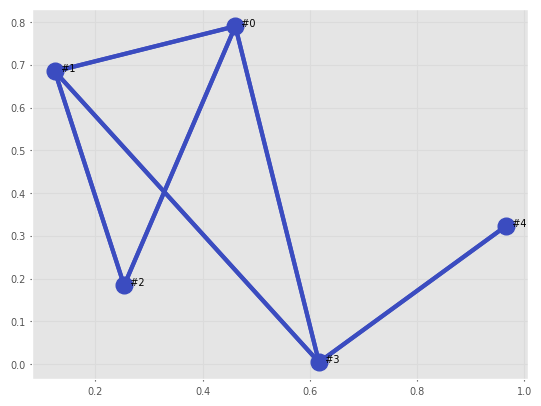

In [9]:
g.plot()

The vertices are shown as blue circles, and the edges are shown as lines joining vertices. Many options exist to change default plotting behaviour. Note that only graphs embedded in 2- and 3-dimensional space can be plotted.

The neighbors of vertex 1 are

In [10]:
g[1].adjacent()

[UVertex[#0, coord=(0.4611, 0.7902)],
 UVertex[#2, coord=(0.2537, 0.1843)],
 UVertex[#3, coord=(0.6171, 0.004629)]]

which is a list of neighbouring vertex objects, those connected to it by an edge. Each edge is an object and the edges connecting to vertex 1 are

In [11]:
g[1].edges()

[Edge{[#0] -- [#1], cost=0.3527},
 Edge{[#1] -- [#2], cost=0.5168},
 Edge{[#1] -- [#3], cost=0.8398}]

and each edge has references to the vertices it connects

In [12]:
g[1].edges()[0].endpoints

[UVertex[#0, coord=(0.4611, 0.7902)], UVertex[#1, coord=(0.1245, 0.6847)]]

The cost or length of an edge is

In [13]:
g[1].edges()[0].cost

0.35274566778276145

Arbitrary data can be attached to any vertex or edge by adding attributes to the vertex or edge objects, or by subclassing the UVertex and Edge classes.

The vertex closest to the coordinate (0.5, 0.5) is

In [14]:
g.closest((0.5, 0.5))

(UVertex[#0, coord=(0.4611, 0.7902)], 0.2927983932031573)

<br>

<a id='2'></a>
# 2.0 Graph Search
---

We have the following map of Queensland

<img src="./Figures/5/fig5_7.jpg" width="700">

For this example, we consider the towns and cities shown in the figure above, and we import a datafile included with the Toolbox

In [15]:
data = rtb.rtb_load_jsonfile("data/queensland.json")

where data is a dictionary containing two items. Firstly, `data["places"]` is a dictionary that maps place names to a dictionary of attributes such as latitude, longitude and UTM map coordinates in units of kilometres. We can easily plot these places, along with their names

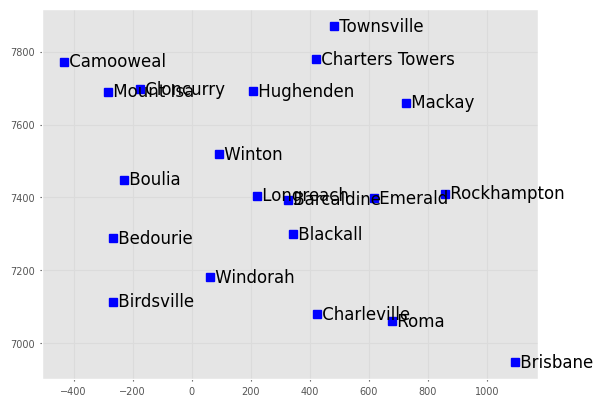

In [16]:
for name, info in data["places"].items():
    smb.plot_point(info["utm"], text=name)

Secondly, `data["routes"]` is a list of dictionaries that each define a graph edge: the name of its start and end place, the route length and the driving speed. For example

In [17]:
data["routes"][0]

{'start': 'Camooweal', 'end': 'Mount Isa', 'distance': 188, 'speed': 100}

We will use the Python `pgraph` package to create a graph representation of the data. The first step is to create an undirected graph object and then add vertices and edges from the data we just loaded

In [18]:
g = pg.UGraph()

for name, info in data["places"].items():
    g.add_vertex(name=name, coord=info["utm"])

for route in data["routes"]:
    g.add_edge(route["start"], route["end"], cost=route["distance"])


The `UGraph` object has many methods, for example, we can plot the graph we just created

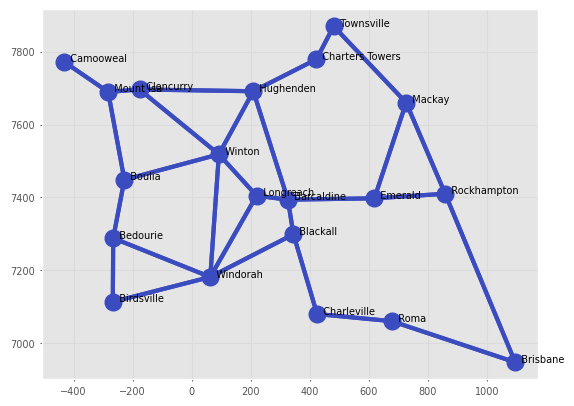

In [19]:
g.plot()

We can retrieve a vertex by its name

In [20]:
g["Brisbane"]

UVertex[Brisbane, coord=(1096, 6947)]

which is an object of UVertex class which represents a vertex in an undirected graph. Its neighbors, or adjacent vertices, are

In [21]:
g["Brisbane"].adjacent()

[UVertex[Rockhampton, coord=(858.9, 7410)], UVertex[Roma, coord=(677.7, 7060)]]

We can obtain references to the Edge objects that represent the edges. A list of the edges from the Brisbane vertex is given by

In [22]:
edges = g["Brisbane"].edges()
print(edges)

[Edge{[Rockhampton] -- [Brisbane], cost=682}, Edge{[Brisbane] -- [Roma], cost=482}]


and each edge has references to its endpoints

In [23]:
edges[0].endpoints

[UVertex[Rockhampton, coord=(858.9, 7410)],
 UVertex[Brisbane, coord=(1096, 6947)]]

Now, we are ready to plan a path, and will consider the specific example of a journey from Brisbane to Barcaldine. A simple-minded solution would be to randomly choose one of the neighbouring vertices, move there, and repeat the process. We might eventually reach our goal – but there is no guarantee of that – and it is extremely unlikely that the path would be optimal. A more systematic approach is required and we are fortunate this problem has been well-studied – it is the well-known graph search problem.

Starting at Brisbane, there are just two roads we can take to get to a neighbouring place. From one of those places, say Roma, we can visit in turn each of its neighbors. However, one of those neighbors is Brisbane, our starting point, and backtracking cannot lead to an optimal path. We need some means of keeping track of where we have been. The frontier (or open set) contains all the vertices that are scheduled for exploration, and the explored set (or closed set) contains all the vertices that we have explored and are finished with.

We will introduce three algorithms and explain them without code, as the code solutions will be your assignments for Assessment 1.5 and 1.6.

## 2.1 Breadth First Search

We will start at Brisbane and we want to travel to Barcaldine. We will keep two lists, the Frontier and a Visited List.

The Frontier is a first in - first out (fifo) queue and the visited list will keep track of the nodes we have visited.

**Iteration 0**:

We start by adding Brisbane to the `Frontier` and the `Visited` List is empty

`Frontier`: Brisbane

`Visited`: *Empty*

At each iteration, we take the first node from the Frontier and add it to the Visited List. We then add all the neighbours of that node to the Frontier. We repeat this process until we reach the goal node.

**Iteration 1**:

We move Brisbane to `Visited`, and add Brisbane's neighbouring nodes to the `Frontier`

`Frontier`: Roma, Rockhampton

`Visited`: Brisbane

**Iteration 2**:

We move Roma to `Visited`, and add Roma's neighbouring nodes to the `Frontier`

`Frontier`: Rockhampton, Charleville

`Visited`: Brisbane, Roma

**Iteration 3**:

We move Rockhampton to `Visited`, and add Rockhampton's neighbouring nodes to the `Frontier`

`Frontier`: Charleville, Emerald, Mackay

`Visited`: Brisbane, Roma, Rockhampton

**Iteration 4**:

We move Charleville to `Visited`, and add Charleville's neighbouring nodes to the `Frontier`

`Frontier`: Emerald, Mackay, Blackall

`Visited`: Brisbane, Roma, Rockhampton, Charleville

**Iteration 5**:

We move Emerald to `Visited`, and add Emerald's neighbouring nodes to the `Frontier`

`Frontier`: Mackay, Blackall, Barcaldine

`Visited`: Brisbane, Roma, Rockhampton, Charleville, Emerald

And we have found our goal node Barcaldine, so we stop. We can collapse our search into the path that led to the goal node:

Brisbane -> Rockhampton -> Emerald -> Barcaldine

We can see that the path we found is the shortest in terms of nodes visited from Brisbane to Barcaldine. If the planning algorithm kept going for another iteration, then it would have found the path:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine

While BFS found the shortest path in terms of nodes visited, it did not find the shortest path in terms of distance travelled.

## 2.2 Uniform Cost Search

A variation of this search is uniform-cost-search (UCS). In the previous search, we expanded vertices from the frontier on a first-in first-out basis, but now we will choose the frontier vertex that has the lowest cumulative distance from the start – the lowest cost to come.

**Iteration 0**:

We start by adding Brisbane to the `Frontier` and the `Visited` List is empty

`Frontier`: Brisbane

`Visited`: *Empty*

At each iteration, we take the lowest cumulative distance from Brisbane from the Frontier and add it to the Visited List. We then add all the neighbours of that node to the Frontier. We repeat this process until we reach the goal node.



In [24]:
g["Brisbane"].edges()

[Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Brisbane] -- [Roma], cost=482}]

**Iteration 1**:

We move Brisbane to `Visited`, and add Brisbane's neighbouring nodes to the `Frontier`

`Frontier`: Roma (482), Rockhampton (682)

`Visited`: Brisbane



**Iteration 1**:

We will expand Roma as it has the lowest cumulative distance from Brisbane

In [25]:
g["Roma"].edges()

[Edge{[Brisbane] -- [Roma], cost=482}, Edge{[Roma] -- [Charleville], cost=266}]

`Frontier`: Rockhampton (682), Charleville (482 + 266 = 748)

`Visited`: Brisbane, Roma (482)

**Iteration 2**:

The next lowest is Rockhampton

In [26]:
g["Rockhampton"].edges()

[Edge{[Mackay] -- [Rockhampton], cost=334},
 Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Rockhampton] -- [Emerald], cost=270}]

`Frontier`: Charleville (748), Emerald (682 + 270 = 952), Mackay (682 + 334 = 1016)

`Visited`: Brisbane, Roma (482), Rockhampton (682)

**Iteration 3**:

The next lowest is Charleville

In [27]:
g["Charleville"].edges()

[Edge{[Roma] -- [Charleville], cost=266},
 Edge{[Charleville] -- [Blackall], cost=305}]

`Frontier`: Emerald (952), Mackay (1016), Blackall (748 + 305 = 1053)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748)

**Iteration 4**:

The next lowest is Emerald

In [28]:
g["Emerald"].edges()

[Edge{[Mackay] -- [Emerald], cost=384},
 Edge{[Rockhampton] -- [Emerald], cost=270},
 Edge{[Barcaldine] -- [Emerald], cost=307}]

`Frontier`: Mackay (1016), Blackall (1053), Barcaldine (952 + 307 = 1259), Mackay (952 + 384 = 1336), Rockhampthon (952 + 270 = 1222)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952)

_Remove the new Rockhampton and Mackay from the Frontier as they are already in the Frontier with a lower cumulative distance_

`Frontier`: Mackay (1016), Blackall (1053), Barcaldine (1259)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952)

With UCS, we may encounter places that are already on our Frontier or Visited lists. In this scenario, we will replace the existing node with the new node if the new node has a lower cumulative distance from Brisbane. Since the new routes to Mackay and Rockhampton are both longer than the existing routes, we will not replace them.

We have found our goal node Barcaldine, but we do not stop with UCS until all nodes are visited.

**Iteration 5**:

The next lowest is Mackay

In [29]:
g["Mackay"].edges()

[Edge{[Townsville] -- [Mackay], cost=388},
 Edge{[Mackay] -- [Rockhampton], cost=334},
 Edge{[Mackay] -- [Emerald], cost=384}]

`Frontier`: Blackall (1053), Barcaldine (1259), Townsville (1016 + 388 = 1404), Emerald (1016 + 384 = 1400)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016)

Remove the new Emerald from the Frontier as it is already in the Visited with a lower cumulative distance

`Frontier`: Blackall (1053), Barcaldine (1259), Townsville (1404)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016)

**Iteration 6**:

The next lowest is Blackall

In [30]:
g["Blackall"].edges()

[Edge{[Charleville] -- [Blackall], cost=305},
 Edge{[Blackall] -- [Barcaldine], cost=106},
 Edge{[Blackall] -- [Windorah], cost=530}]

`Frontier`: Barcaldine (1259), Townsville (1404), Windorah (1053 + 530 = 1583), Barcaldine (1053 + 106 = 1159)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016), Blackall (1053)

Remove the old Barcaldine from the Frontier as the new route has a lower cumulative distance

`Frontier`: Townsville (1404), Windorah (1053 + 530 = 1583), Barcaldine (1159)

`Visited`: Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016), Blackall (1053)

And our new best route to Barcaldine is:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine with a total cost of 1159

The UCS search will continue until all nodes in the graph has been visited. This can be expensive for very large graphs. This type of algorithm is known as a **brute force** algorithm. It is guaranteed to find the best solution, but it search the whole solution space to do so, which can be very computationally expensive.

## 2.3 A* Search

A* is a variation on the UCS algorithm but we use a _heuristic_ to guide our path. A commonly used heuristic is the distance "as the crow flies" or Euclidean distance – easily computed since our graph is embedded and the position of every vertex is known.

To calculate the Euclidean distance between each node and Barcaldine, we simply loop through nodes in the graph

In [31]:
barcaldine_coords = g["Barcaldine"].coord

for node in g:
    euc_dist = np.linalg.norm(barcaldine_coords - node.coord)
    print(f"{node.name}: {np.round(euc_dist)}")
    

Brisbane: 890.0
Camooweal: 847.0
Mount Isa: 677.0
Cloncurry: 587.0
Hughenden: 320.0
Charters Towers: 398.0
Townsville: 501.0
Boulia: 557.0
Winton: 265.0
Bedourie: 601.0
Birdsville: 656.0
Windorah: 338.0
Longreach: 107.0
Barcaldine: 0.0
Blackall: 97.0
Charleville: 329.0
Roma: 485.0
Emerald: 293.0
Mackay: 481.0
Rockhampton: 533.0


And we will use these numbers as our heuristic. The total cost we will use for each node is the cumulative distance from Brisbane plus the Euclidean distance to Barcaldine.

**Iteration 0**:

We start by adding Brisbane to the `Frontier` and the `Visited` List is empty

`Frontier`: Brisbane

`Visited`: *Empty*

**Iteration 1**:

We move Brisbane to `Visited`, and add Brisbane's neighbouring nodes to the `Frontier`

`Frontier`: Roma (485 + 482 = 967), Rockhampton (533 + 682 = 1215)

`Visited`: Brisbane

In [32]:
g["Brisbane"].edges()

[Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Brisbane] -- [Roma], cost=482}]

**Iteration 2**:

We move Roma to `Visited`, and add Roma's neighbouring nodes to the `Frontier`

`Frontier`: Rockhampton (533 + 682 = 1215), Charleville (329 + 482 + 266 = 1077)

`Visited`: Brisbane, Roma (485 + 482 = 967)

In [33]:
g["Roma"].edges()

[Edge{[Brisbane] -- [Roma], cost=482}, Edge{[Roma] -- [Charleville], cost=266}]

**Iteration 3**:

We move Charleville to `Visited`, and add Charleville's neighbouring nodes to the `Frontier`

`Frontier`: Rockhampton (533 + 682 = 1215), Blackall (97 + 482 + 266 + 305 = 1150)

`Visited`: Brisbane, Roma (485 + 482 = 967), Charleville (329 + 482 + 266 = 1077)

In [34]:
g["Charleville"].edges()

[Edge{[Roma] -- [Charleville], cost=266},
 Edge{[Charleville] -- [Blackall], cost=305}]

**Iteration 4**:

We move Blackall to `Visited`, and add Blackall's neighbouring nodes to the `Frontier`

`Frontier`: Rockhampton (533 + 682 = 1215), Barcaldine (0 + 482 + 266 + 305 + 106 = 1159), Windorah (338 + 482 + 266 + 305 + 530 = 1921)

`Visited`: Brisbane, Roma (485 + 482 = 967), Charleville (329 + 482 + 266 = 1077), Blackall (97 + 482 + 266 + 305 = 1150)

In [35]:
g["Blackall"].edges()

[Edge{[Charleville] -- [Blackall], cost=305},
 Edge{[Blackall] -- [Barcaldine], cost=106},
 Edge{[Blackall] -- [Windorah], cost=530}]

And we have found our goal node Barcaldine, so we stop. We can collapse our search into the path that led to the goal node:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine with a total cost of 1159 which is the lowest cost solution, and we found it in just 5 iterations (the same as BFS).

The performance of A* depends critically on the heuristic. A* is guaranteed to return the lowest-cost path only if the heuristic is admissible, that is, it does not overestimate the cost of reaching the goal. The Euclidean distance is an admissible heuristic since it is the minimum possible cost and by definition cannot be an overestimate. As the heuristic cost component increases from zero up to its maximum admissible value, the efficiency increases as fewer vertices are explored. A non-admissible heuristic may lead to a non-optimal path.

## 2.4 Depth First Search

With Depth-first search (DFS), the frontier becomes a last in - first out (lifo) structure known as a _stack_. This means that the last node added to the frontier will be the first node removed from the frontier. This is the opposite of the breadth-first search (BFS) algorithm.

To make it simpler, have transformed our graph into a tree and removed some connections. The root node is Brisbane and the goal node is Barcaldine



<img src="Figures/5/map.png" alt="dfs" style="width: 400px" />


**Iteration 0**:

On each iteration we go through the depth of the tree adding the first unvisited child node to the Frontier, until there is no more child nodes to add.

We start by adding Brisbane and its first child node, and its child's first child node etc until we run out the last node has no children to the `Frontier` and the `Visited` List is empty

`Frontier`: Brisbane, Rockhampton, Mackay, Townsville, Charters Towers

`Visited`: *Empty*

**Iteration 1**:

And then we pop the last node off the `Frontier` and add it to the `Visited` List. We then add its first child (and its child's first child etc (that we have not visited yet)) to the `Frontier` and repeat until we reach the goal node.

`Frontier`: Brisbane, Rockhampton, Mackay, Townsville, 

`Visited`: Charters Towers

**Iteration 2**:

Charters Towers has no other child so no other nodes are added to the `Frontier` and we move on to the next node in the `Frontier` which is Townsville

`Frontier`: Brisbane, Rockhampton, Mackay

`Visited`: Charters Towers, Townsville

**Iteration 3**:

`Frontier`: Brisbane, Rockhampton

`Visited`: Charters Towers, Townsville, Mackay

**Iteration 4**:

`Frontier`: Brisbane, Emerald

`Visited`: Charters Towers, Townsville, Mackay, Rockhampton

**Iteration 5**:

`Frontier`: Brisbane

`Visited`: Charters Towers, Townsville, Mackay, Rockhampton, Emerald

**Iteration 6**:

`Frontier`: Brisbane, Roma, Charleville, Blackall, Barcaldine

`Visited`: Charters Towers, Townsville, Mackay, Rockhampton, Emerald

And we stop because we have reached the goal node. We can collapse our search into the path that led to the goal node:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine

Note that with a tree, with a recursive implementation, we do not need to keep a Visited list since there are no closed loops in the graph.

If our graph is not a tree, but some other general form of graph, instead of adding child nodes we add a neighbour of the current node that hasn't been visited yet, until there is no more neighbours to add.

Let's try this with the original map of Queensland

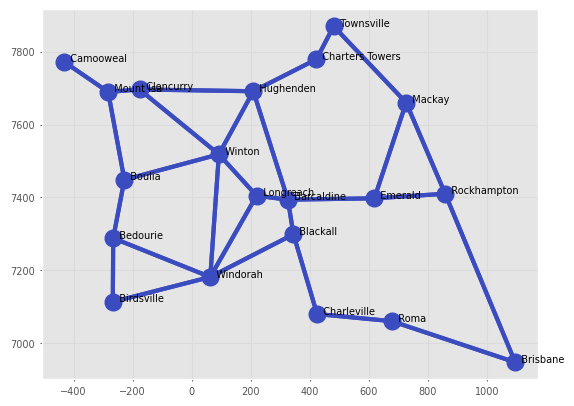

In [36]:
g.plot()

**Iteration 0**:

`Frontier`: Brisbane, Rockhampton, Mackay, Townsville, Charters Towers, Hughenden, Cloncurry, Mount Isa, Camooweal

`Visited`: *Empty*

**Iteration 1**:

`Frontier`: Brisbane, Rockhampton, Mackay, Townsville, Charters Towers, Hughenden, Cloncurry, Mount Isa

`Visited`: Camooweal

**Iteration 2**:

`Frontier`: Brisbane, Rockhampton, Mackay, Townsville, Charters Towers, Hughenden, Cloncurry, Beulia, Winton, Longreach, Barcaldine

`Visited`: Camooweal, Mount Isa

And we stop because we have reached our goal node. We can collapse our search into the path that led to the goal node:

Brisbane -> Rockhampton -> Mackay -> Townsville -> Charters Towers -> Hughenden -> Cloncurry -> Mount Isa -> Beulia -> Winton -> Longreach -> Barcaldine

This many more steps in this path than the path we found with BFS and the distance travelled is going to be far greater than UCS and A*. Of course, we could have been very lucky if we chose Roma as our first neighbour to explore in which case we could have reached the goal on the first iteration.

### BFS vs DFS

BFS is guaranteed to find the shortest path, but it is not guaranteed to use the fewest number of steps. DFS may find a solution in fewer steps but it is not guaranteed to find the shortest path. In the worst case scenario, both DFS and BFS may explore every node in the graph making them as slow as each other. With a tree, DFS is more memory efficient in general as it only needs to keep a stack of of the path from the root node to the current node, whereas the BFS frontier queue grows with the tree's width and depth.

For example, if we have a tree with a depth of 5 and each node has 10 children -- referred to as the branching factor, this tree has a branching factor of 10 -- there will be 5^10 nodes in the tree. If we have a goal node that is at the bottom right of the tree (the worst case scenario for both BFS and DFS), then the maximum size of the DFS stack will be 5 at any time, whereas the BFS queue could grow to 5^10.

In practice, these points will depend on the implementation of the algorithm and the structure of the graph. For example, if we implement DFS in an iterative manner with a stack and a visited list, then the memory requirements will be the same as BFS.